/tmp/ipykernel_21473/590031383.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


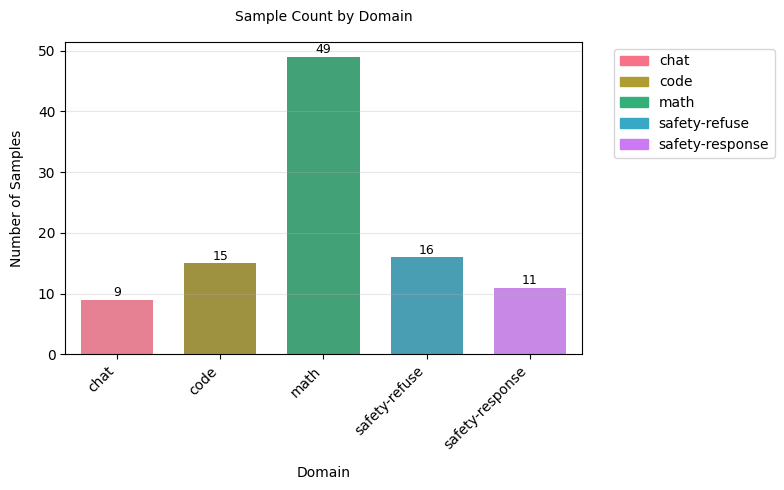

,Domain,Count
2,chat,9
3,code,15
0,math,49
1,safety-refuse,16
4,safety-response,11


,Method,Correct Count,Error Count
0,BASELINE,74,26
1,COT,69,31
2,CRITIC,83,17
3,SOP,84,16


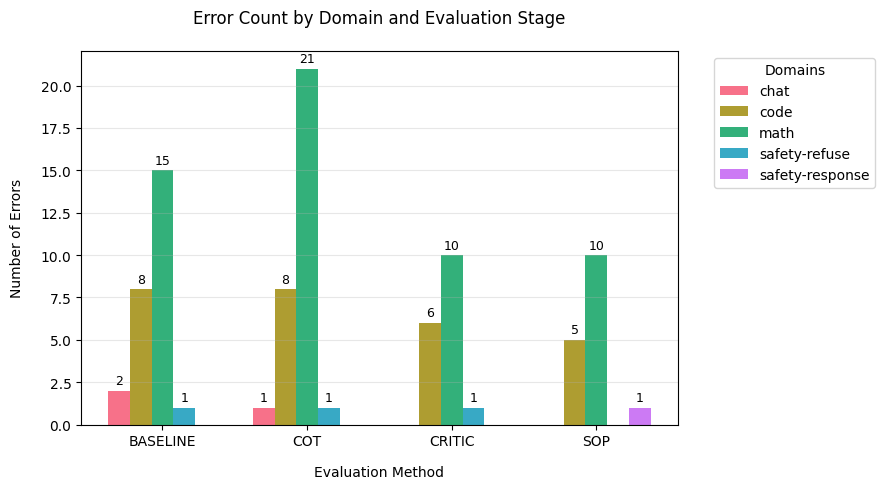

Method,BASELINE,COT,CRITIC,SOP
Domain,,,,
chat,2,1,0,0
code,8,8,6,5
math,15,21,10,10
safety-refuse,1,1,1,0
safety-response,0,0,0,1


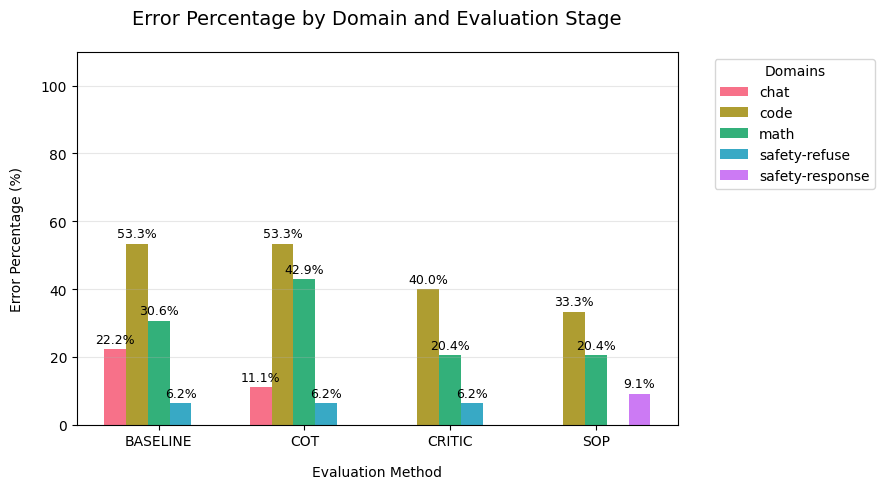

Method,BASELINE,COT,CRITIC,SOP
Domain,,,,
chat,22.2%,11.1%,0.0%,0.0%
code,53.3%,53.3%,40.0%,33.3%
math,30.6%,42.9%,20.4%,20.4%
safety-refuse,6.2%,6.2%,6.2%,0.0%
safety-response,0.0%,0.0%,0.0%,9.1%


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import defaultdict
from IPython.display import display
from matplotlib.colors import to_hex

# Load the dataset
with open("detailed_results.json") as f:
    data = json.load(f)

# Set up a consistent color palette for all plots
all_domains = sorted(set(item["domain"] for method in data.values() for item in method["details"]))
palette = sns.color_palette("husl", n_colors=len(all_domains))  # Same palette for all plots
methods = sorted(data.keys())

# ======================================================================
# 1. Domain Distribution Plot
# ======================================================================
plt.figure(figsize=(8, 5))
domain_counts = defaultdict(int)
for sample in data[methods[0]]["details"]:
    domain_counts[sample["domain"]] += 1

df_counts = pd.DataFrame({
    "Domain": list(domain_counts.keys()),
    "Count": list(domain_counts.values())
}).sort_values("Domain")

ax1 = sns.barplot(
    data=df_counts,
    x="Domain",
    y="Count",
    palette=palette,
    width=0.7,
    order=df_counts["Domain"]
)

for p in ax1.patches:
    ax1.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
        fontsize=9
    )

plt.title("Sample Count by Domain", pad=15, fontsize=10)
plt.xlabel("Domain", labelpad=10)
plt.ylabel("Number of Samples", labelpad=10)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
legend_labels = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(df_counts))]
plt.legend(legend_labels, df_counts["Domain"], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display the counts table with matching colors
def color_row(row):
    color = palette[row.name % len(palette)]
    return [f'background-color: {to_hex(color)}'] * len(row)
    
display(df_counts.style.apply(color_row, axis=1).set_caption("Domain Distribution Across Dataset"))

# ======================================================================
# 4. Total Correct Outputs by Evaluation Stage
# ======================================================================

# Calculate total correct outputs for each method
correct_counts = []
for method in methods:
    total_samples = len(data[method]["details"])
    error_count = sum(len(errors) for errors in data[method]["domain_errors"].values())
    correct_count = total_samples - error_count
    correct_counts.append({
        "Method": method.upper(),
        "Correct Count": correct_count,
        "Error Count": error_count
    })

df_correct = pd.DataFrame(correct_counts)

# Display the data table with correct/error counts
display(df_correct.style \
    .background_gradient(subset=["Correct Count"], cmap="Greens") \
    .background_gradient(subset=["Error Count"], cmap="Reds") \
    .set_caption("Correct and Error Counts by Evaluation Method"))

# ======================================================================
# 2. Error Count by Domain and Method
# ======================================================================
plt.figure(figsize=(9, 5))

# Create error count matrix
error_data = []
for domain in all_domains:
    for method in methods:
        error_count = len(data[method]["domain_errors"].get(domain, []))
        error_data.append({
            "Domain": domain,
            "Method": method.upper(),
            "Error Count": error_count
        })

df_errors = pd.DataFrame(error_data)

# Create positions for clustered bars
x_pos = np.arange(len(methods))
bar_width = 0.15

# Plot each domain's error bars
for i, domain in enumerate(all_domains):
    domain_errors = df_errors[df_errors["Domain"] == domain]
    plt.bar(
        x_pos + i * bar_width,
        domain_errors["Error Count"],
        width=bar_width,
        label=domain,
        color=palette[i]
    )

# Add value labels
for i, domain in enumerate(all_domains):
    domain_errors = df_errors[df_errors["Domain"] == domain]
    for j, count in enumerate(domain_errors["Error Count"]):
        if count > 0:
            plt.text(
                x_pos[j] + i * bar_width,
                count + 0.2,
                str(count),
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title("Error Count by Domain and Evaluation Stage", pad=20, fontsize=12)
plt.xlabel("Evaluation Method", labelpad=12)
plt.ylabel("Number of Errors", labelpad=12)
plt.xticks(x_pos + bar_width * (len(all_domains)-1)/2, [m.upper() for m in methods])
plt.legend(title="Domains", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display error count table
error_table = df_errors.pivot_table(
    index="Domain",
    columns="Method",
    values="Error Count",
    aggfunc="sum",
    fill_value=0
)
display(error_table.style.background_gradient(cmap="Reds").set_caption("Error Count by Domain and Method"))

# ======================================================================
# 3. Error Percentage by Domain and Method
# ======================================================================
plt.figure(figsize=(9, 5))

# Calculate total samples per domain
domain_totals = {domain: 0 for domain in all_domains}
for item in data[methods[0]]["details"]:
    domain_totals[item["domain"]] += 1

# Calculate error percentages
error_percent_data = []
for domain in all_domains:
    for method in methods:
        error_count = len(data[method]["domain_errors"].get(domain, []))
        total = domain_totals[domain]
        percentage = (error_count / total) * 100 if total > 0 else 0
        error_percent_data.append({
            "Domain": domain,
            "Method": method.upper(),
            "Error Percentage": percentage
        })

df_percent = pd.DataFrame(error_percent_data)

# Create positions for clustered bars
x_pos = np.arange(len(methods))
bar_width = 0.15

# Plot each domain's error percentages
for i, domain in enumerate(all_domains):
    domain_data = df_percent[df_percent["Domain"] == domain]
    plt.bar(
        x_pos + i * bar_width,
        domain_data["Error Percentage"],
        width=bar_width,
        label=domain,
        color=palette[i]
    )

# Add percentage labels
for i, domain in enumerate(all_domains):
    domain_data = df_percent[df_percent["Domain"] == domain]
    for j, percent in enumerate(domain_data["Error Percentage"]):
        if percent > 0:
            plt.text(
                x_pos[j] + i * bar_width,
                percent + 1,
                f"{percent:.1f}%",
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title("Error Percentage by Domain and Evaluation Stage", pad=20, fontsize=14)
plt.xlabel("Evaluation Method", labelpad=12)
plt.ylabel("Error Percentage (%)", labelpad=12)
plt.xticks(x_pos + bar_width * (len(all_domains)-1)/2, [m.upper() for m in methods])
plt.legend(title="Domains", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 110)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display percentage table
percent_table = df_percent.pivot_table(
    index="Domain",
    columns="Method",
    values="Error Percentage",
    aggfunc="sum",
    fill_value=0
).round(1)
display(percent_table.style.background_gradient(cmap="Reds", vmin=0, vmax=100).format("{:.1f}%").set_caption("Error Percentage by Domain and Method"))